## Prepare some utils

In [26]:
#prepare the utils from torchvision framework
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py

--2024-02-06 07:27:48--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23628 (23K) [text/plain]
Saving to: ‘transforms.py.1’

transforms.py.1     100%[===================>]  23.07K  --.-KB/s    in 0.002s  

2024-02-06 07:27:49 (14.0 MB/s) - ‘transforms.py.1’ saved [23628/23628]

--2024-02-06 07:27:49--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4

## Prepare the datasets

In [2]:
# prepare the datasets
#!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
#!unzip PennFudanPed.zip -d PennFudanPed

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [41]:
import os
'/content/drive/MyDrive/indonesia ai/project 3/Dataset/images_prepped_test'

In [5]:
destination_folder = '/content/drive/MyDrive/indonesia ai/project 3/Dataset'
train_img_path = os.path.join(destination_folder, 'images_prepped_train')
train_annot_path = os.path.join(destination_folder, 'annotations_prepped_train')

test_img_path = os.path.join(destination_folder, 'images_prepped_test')
test_annot_path = os.path.join(destination_folder, 'annotations_prepped_test')

In [6]:
print(f'total train images: {len(os.listdir(train_img_path))}')
print(f'total train annots: {len(os.listdir(train_annot_path))}')
print(f'total test images: {len(os.listdir(test_img_path))}')
print(f'total test annots: {len(os.listdir(test_annot_path))}')

total train images: 367
total train annots: 367
total test images: 101
total test annots: 101


In [7]:
os.listdir(destination_folder)

['images_prepped_train',
 'annotations_prepped_test',
 'images_prepped_test',
 'annotations_prepped_train']

In [8]:
# code is from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, images_path, mask_path):
        self.root = root
        self.transforms = transforms
        self.images_path = images_path
        self.mask_path = mask_path
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, self.images_path))))
        self.masks = list(sorted(os.listdir(os.path.join(root, self.mask_path))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, self.images_path, self.imgs[idx])
        mask_path = os.path.join(self.root, self.mask_path, self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = idx
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
# code is from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
# code is from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [15]:
dataset = PennFudanDataset(destination_folder, get_transform(train=True), "images_prepped_train", "annotations_prepped_train")
dataset.imgs[1]

'0001TP_006720.png'

In [12]:
dataset[1]

(tensor([[[0.0706, 0.0588, 0.0471,  ..., 0.1490, 0.1686, 0.1686],
          [0.0745, 0.0627, 0.0510,  ..., 0.1569, 0.1608, 0.1529],
          [0.0784, 0.0706, 0.0588,  ..., 0.1412, 0.1451, 0.1647],
          ...,
          [0.0627, 0.0667, 0.0667,  ..., 0.1216, 0.1020, 0.0902],
          [0.0549, 0.0627, 0.0627,  ..., 0.1216, 0.1176, 0.0980],
          [0.0510, 0.0588, 0.0627,  ..., 0.0863, 0.0902, 0.0941]],
 
         [[0.0667, 0.0549, 0.0431,  ..., 0.1843, 0.2039, 0.2078],
          [0.0745, 0.0627, 0.0510,  ..., 0.1961, 0.2039, 0.1961],
          [0.0745, 0.0706, 0.0549,  ..., 0.1843, 0.1882, 0.2078],
          ...,
          [0.0667, 0.0706, 0.0706,  ..., 0.1569, 0.1451, 0.1294],
          [0.0588, 0.0667, 0.0667,  ..., 0.1608, 0.1569, 0.1333],
          [0.0549, 0.0627, 0.0667,  ..., 0.1294, 0.1333, 0.1255]],
 
         [[0.0667, 0.0549, 0.0431,  ..., 0.1882, 0.2078, 0.2078],
          [0.0745, 0.0627, 0.0510,  ..., 0.2000, 0.2039, 0.1961],
          [0.0745, 0.0706, 0.0549,  ...,

In [13]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/segmentation/train.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/segmentation/presets.py

--2024-02-06 07:14:34--  https://raw.githubusercontent.com/pytorch/vision/main/references/segmentation/train.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13423 (13K) [text/plain]
Saving to: ‘train.py’

train.py            100%[===================>]  13.11K  --.-KB/s    in 0s      

2024-02-06 07:14:34 (62.0 MB/s) - ‘train.py’ saved [13423/13423]

--2024-02-06 07:14:34--  https://raw.githubusercontent.com/pytorch/vision/main/references/segmentation/presets.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588 (3.5K) [text/p

In [32]:
# code is from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
from engine import train_one_epoch, evaluate
import utils
import torch
import torch.nn as nn


#def train():
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset(destination_folder, get_transform(train=True), 'images_prepped_train', 'annotations_prepped_train')
dataset_test = PennFudanDataset(destination_folder, get_transform(train=False), 'images_prepped_test', 'annotations_prepped_test')

# split the dataset in train and test set
#indices = torch.randperm(len(dataset)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9,
                            nesterov = True,
                            weight_decay=0.0005
                             )

# and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
 #                                               step_size=3,
  #                                              gamma=0.1)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler



# let's train it for 20 epochs
num_epochs = 20
hasil = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metrics_train = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    loss_list = metrics_train.meters.get('loss')
    hasil.append([epoch, metrics_train.meters.get('lr'), metrics_train.meters.get('loss'), metrics_train.meters.get('loss_classifier'),
                  metrics_train.meters.get('loss_box_reg'), metrics_train.meters.get('loss_objectness'), metrics_train.meters.get('loss_rpn_box_reg')])

    print("Loss_value: ", loss_list.value)

    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    hasil_eval = evaluate(model, data_loader_test, device=device)
    hasil_eval

#return metrics_train, hasil, hasil_eval

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: [0]  [  0/184]  eta: 0:05:37  lr: 0.000032  loss: 5.1171 (5.1171)  loss_classifier: 0.7361 (0.7361)  loss_box_reg: 0.4108 (0.4108)  loss_mask: 2.6651 (2.6651)  loss_objectness: 0.7879 (0.7879)  loss_rpn_box_reg: 0.5172 (0.5172)  time: 1.8346  data: 1.1921  max mem: 6749
Epoch: [0]  [ 10/184]  eta: 0:01:57  lr: 0.000305  loss: 3.9035 (3.7389)  loss_classifier: 0.5656 (0.5680)  loss_box_reg: 0.3909 (0.3777)  loss_mask: 1.6948 (1.7548)  loss_objectness: 0.6727 (0.7445)  loss_rpn_box_reg: 0.2210 (0.2940)  time: 0.6761  data: 0.1161  max mem: 6916
Epoch: [0]  [ 20/184]  eta: 0:01:43  lr: 0.000578  loss: 2.1625 (2.8319)  loss_classifier: 0.3347 (0.4436)  loss_box_reg: 0.3983 (0.3927)  loss_mask: 1.0401 (1.2793)  loss_objectness: 0.1395 (0.4405)  loss_rpn_box_reg: 0.2153 (0.2758)  time: 0.5713  data: 0.0096  max mem: 6916
Epoch: [0]  [ 30/184]  eta: 0:01:35  lr: 0.000851  loss: 1.7551 (2.4863)  loss_classifier: 0.3108 (0.3971)  loss_box_reg: 0.4384 (0.4290)  loss_mask: 0.6316 (1.0643) 

In [46]:
images_dataset = PennFudanDataset(destination_folder, get_transform(train=False), "images_prepped_test", "annotations_prepped_test")
images_dataset.imgs[50]

'0016E5_08059.png'

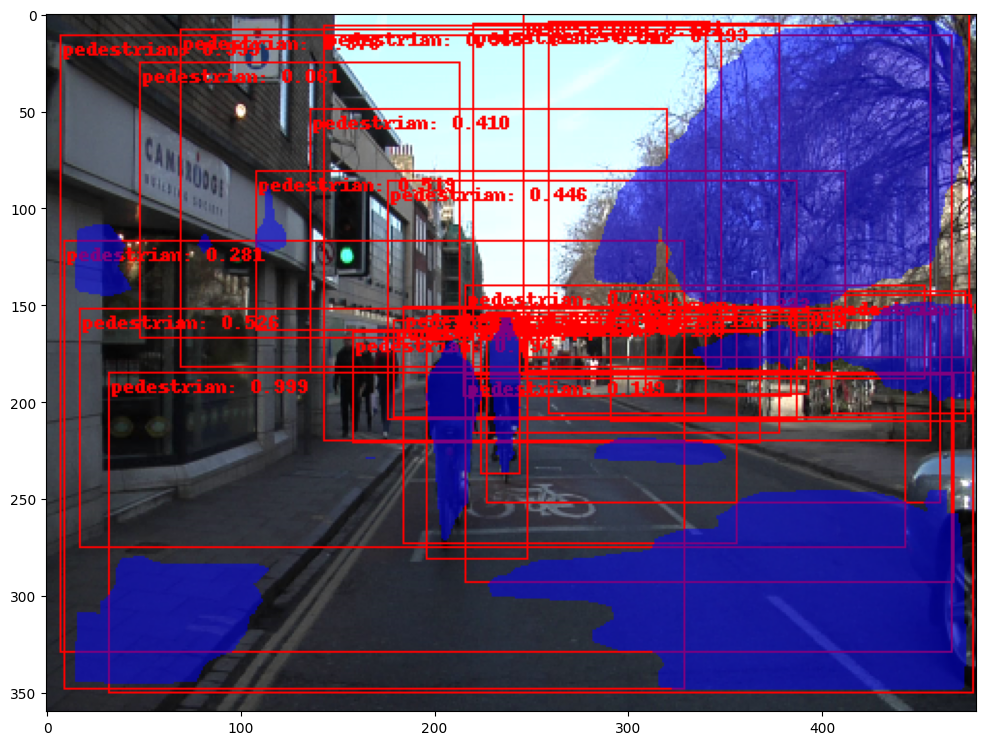

In [49]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image('/content/drive/MyDrive/indonesia ai/project 3/Dataset/images_prepped_test/0016E5_08059.png')
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [42]:

read_image('/content/drive/MyDrive/indonesia ai/project 3/Dataset/images_prepped_test/0016E5_07961.png')

tensor([[[ 31,  33,  34,  ..., 100, 105, 128],
         [ 30,  33,  31,  ...,  81, 103,  83],
         [ 32,  32,  30,  ...,  86,  69,  73],
         ...,
         [ 19,  21,  20,  ...,  36,  36,  34],
         [ 18,  19,  19,  ...,  36,  35,  37],
         [ 19,  19,  21,  ...,  41,  37,  36]],

        [[ 15,  15,  13,  ..., 101, 108, 141],
         [ 14,  17,  13,  ...,  78, 102,  89],
         [ 19,  16,  13,  ...,  84,  65,  76],
         ...,
         [ 20,  22,  21,  ...,  44,  44,  41],
         [ 19,  20,  19,  ...,  41,  40,  41],
         [ 20,  20,  22,  ...,  46,  42,  40]],

        [[ 18,  19,  18,  ..., 113, 121, 145],
         [ 17,  20,  17,  ..., 108, 116,  84],
         [ 21,  19,  17,  ..., 134,  95,  84],
         ...,
         [ 22,  24,  23,  ...,  52,  52,  51],
         [ 22,  23,  22,  ...,  50,  49,  53],
         [ 22,  22,  24,  ...,  55,  51,  52]]], dtype=torch.uint8)